In [58]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def gaussian_function_1d(x,  *args):
    
    sigma_x, mu_x= args
    x_now = x - mu_x
    return np.exp(-(x_now*x_now)/(2*sigma_x**2)) /( np.sqrt(2 * np.pi) * sigma_x )


def coordinate_make(x_len, y_len, dx, dy):
    x = np.arange(0,x_len * dx, dx)
    y = np.arange(0,y_len * dy, dy)
    x_shift = x - np.mean(x)
    y_shift = y - np.mean(y)
    xx, yy= np.meshgrid(x_shift, y_shift, indexing='ij')
    return xx, yy
    
def ring_make(x_len, y_len, dx, dy, r_main, width, function = gaussian_function_1d):
    
    
    xx, yy = coordinate_make(x_len, y_len, dx, dy)


    args = (width, r_main)
    r = (0.5*xx**2 + yy**2) **0.5
    return function(r, *args), xx, yy

def gauss_2d(mu, mu2, sigma):
    x = random.gauss(mu, sigma)
    y = random.gauss(mu2, sigma)
    return (x, y)

def image_2dplot(image, lim = 20):
    
        fig = plt. figure(figsize=(8.0, 8.0))
        shape = np.shape(images)
        plt.axes().set_aspect('equal')  
        plt.xlim(- lim, lim)
        plt.ylim(- lim, lim)

        plt.imshow(image, extent = (-50,50, -50, 50))
        plt.show()
        


class observatory:

    def __init__(self, images, obs_num, period, sn, duration, n_pos, radius, target_elevation):
        self.images = images
        self.obs_num =obs_num
        self.period = period
        self.sn = sn
        self.duration = duration
        self.n_pos = n_pos
        self.target_elevation = target_elevation
        self.radius = radius

    def set_antn(self, dim=3):

        posi_obs = []
        count = 0

        while True:
            x = np.random.randn(dim)
            r = np.linalg.norm(x)
            if r != 0.:
                posi_obs.append(x/r)
                
                count += 1
                if count == self.n_pos:
                    break

        self.antn =   self.radius * np.array(posi_obs)

    def uv_vector(self, z_theta, y_theta):
        C_z, S_z = np.cos(z_theta), np.sin(z_theta)
        C_y, S_y = np.cos(y_theta), np.sin(y_theta)
        R_z = np.array([[C_z,-S_z,0],[S_z, C_z,0],[0,0,1]])
        R_y = np.array([[C_y, 0, S_y],[0,1,0],[-S_y,0,C_y]])
        R = np.dot(R_z, R_y)
        e_y = np.array([0,1,0])
        e_x = np.array([1,0,0])
        #e_z = (Cz Sy, Sz Sy, Cy)
        return np.dot(R, e_x), np.dot(R, e_y)



    def time_observation(self,  dim=3, radius = 6000):
        position_obs = self.antn
        print(position_obs)
        time_arr = np.linspace(0, self.duration, self.obs_num)
        C_time = np.cos( time_arr * 2 * np.pi/ self.period)
        S_time = np.sin( time_arr * 2 * np.pi/ self.period)
        n_obs, n_pos = np.shape(position_obs )
        pos_time = []
        
        e_u, e_v = self.uv_vector(self.target_elevation[0], self.target_elevation[1])
        for i in range(n_obs):
            pos_now = position_obs[i]
            pos_time.append([pos_now[0] * C_time - pos_now[1] * S_time, pos_now[0] * S_time + pos_now[1] * C_time, \
                            pos_now[2] * np.ones(len(time_arr))])
        
        pos_time = np.array(pos_time)
        n_obs, n_pos, n_time = np.shape(pos_time)
        uv_arr = []
        for i in range(n_time):
            pos_time_i = pos_time[:,:,i]
            for j in range(n_obs):
                for k in range(n_obs):
                    if j != k:
                        d_pos = pos_time_i[j] - pos_time_i[k]
                        uv_arr.append([np.dot(d_pos, e_u), np.dot(d_pos, e_v)] )
        uv_arr = np.array(uv_arr)
        return uv_arr
    
    def plotter_uv_sampling(self):
        
        fig = plt. figure(figsize=(8.0, 8.0))
        pos_arr = self.time_observation().T
        lim_max= np.max(np.abs(pos_arr))*1.3
        plt.xlim(-lim_max, lim_max)
        plt.ylim(-lim_max, lim_max)
        plt.axes().set_aspect('equal')        
        plt.scatter(pos_arr[0,:], pos_arr[1,:], s = 1)
        plt.show()
        return pos_arr
        
        
    def obs_make(self, dx, dy, sn):
        
        fft_now = np.fft.fft2(self.images)
        fft_now = np.fft.fftshift(fft_now)
        vis = np.zeros(np.shape(fft_now), dtype=np.complex)
        
        uv_arr = self.time_observation().T
        x_len, y_len = np.shape(self.images)
        u_max = 0.5/dx
        v_max = 0.5/dy
        du = 1/(dx * x_len)
        dv = 1/(dx * y_len)
        u= np.arange(0,x_len * du, du)
        v = np.arange(0,y_len * dv, dv)
        u_shift = u - np.mean(u)
        v_shift = v - np.mean(v)
        for_bins_u = np.append(u_shift, np.max(u_shift)+du) - du/2
        for_bins_v = np.append(v_shift, np.max(v_shift)+dv) - dv/2
        
        vis = np.zeros(np.shape(fft_now), dtype=np.complex)
        fig = plt.figure(figsize = (12,12))
        ax = fig.add_subplot(111)        
        num_mat= ax.hist2d(uv_arr[0],uv_arr[1], bins=[ for_bins_u, for_bins_v], cmap=cm.jet)
        num_mat = num_mat[0]
        plt.close()
        
        for i in range(x_len):
            for j in range(y_len):
                if num_mat[i][j] !=0:
                    real_now, imag_now = fft_now[i,j].real,  fft_now[i,j].imag
                    real_noise, imag_noise = gauss_2d(real_now, imag_now, (((real_now**2 + imag_now**2)**0.5)/(sn * num_mat[i][j])**0.5))
                    
                    vis[i][j] = real_noise + imag_noise * 1j
        return np.fft.ifftshift(vis), vis, fft_now

                


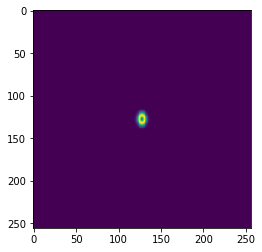

In [59]:
x_len, y_len = 256, 256
dx, dy = 0.01, 0.01
r_main = 0.03
width  = 0.02
data, xx, yy = ring_make(x_len, y_len, dx, dy, r_main, width, function = gaussian_function_1d)
plt.imshow(data)
u_max = 0.5/dx
v_max = 0.5/dy
du = 1/(dx * x_len)
dv = 1/(dx * y_len)
coordinate_make(x_len, y_len, du, dv)
u= np.arange(0,x_len * du, du)
v = np.arange(0,y_len * dv, dv)
u_shift = u - np.mean(u)
v_shift = v - np.mean(v)


[[ -9.58819625   3.45761629  10.37549323]
 [  6.68208765  -3.1234756   12.53527352]
 [  1.72366781 -12.01633118  -8.01100691]
 [ -8.53909912  -8.74013754   7.88880596]
 [ -1.02108155  13.15094124  -6.12777403]
 [ -9.83172485  -9.92020201  -4.05786348]
 [  6.35545654  -0.63537159 -13.06690294]
 [ 11.57656857   8.41021561  -2.60591844]
 [-10.25116999   8.47528091   5.88409761]
 [ -5.40216915  13.49957146   0.34295232]
 [ -3.31580991  14.02241243   1.97909869]
 [-13.10133762   0.6950893   -6.27784047]]


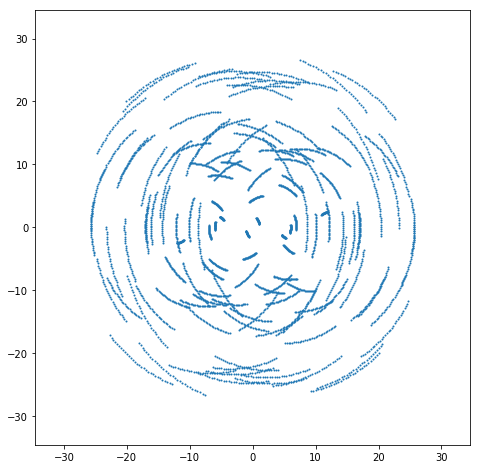

In [69]:
##### images = np.ones((10,10))
imsize = 256
images = np.ones((imsize,imsize))
period = 24
data_num = 30
obs_duration = 2
n_antena = 12
s_n = 100
wavelength = 1#mm
arcsec = 1/206265
radius_km = 3 ##sphere radius
radius_mm = radius_km  * 1000 * 1000 # mm
baseline_mag = radius_mm * arcsec /wavelength ##
obs_ex = observatory(data, data_num , period, s_n, obs_duration , n_antena, baseline_mag, [0., 0.5])
obs_ex.set_antn()
pos_arr =obs_ex.plotter_uv_sampling()

[[ -9.58819625   3.45761629  10.37549323]
 [  6.68208765  -3.1234756   12.53527352]
 [  1.72366781 -12.01633118  -8.01100691]
 [ -8.53909912  -8.74013754   7.88880596]
 [ -1.02108155  13.15094124  -6.12777403]
 [ -9.83172485  -9.92020201  -4.05786348]
 [  6.35545654  -0.63537159 -13.06690294]
 [ 11.57656857   8.41021561  -2.60591844]
 [-10.25116999   8.47528091   5.88409761]
 [ -5.40216915  13.49957146   0.34295232]
 [ -3.31580991  14.02241243   1.97909869]
 [-13.10133762   0.6950893   -6.27784047]]


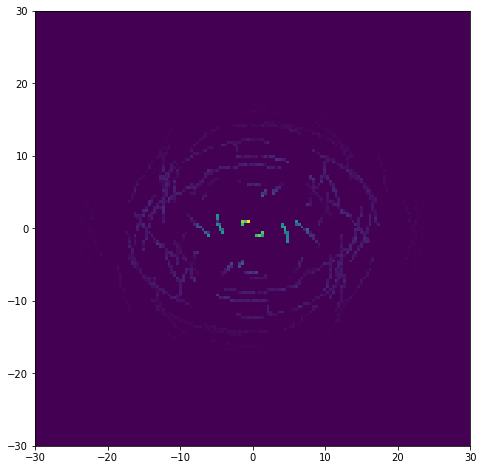

In [70]:
test, vis, fft_now = obs_ex.obs_make(dx, dy, 5)
#vis = np.flip(vis.T, axis = 0)
image_2dplot(np.abs(vis.real), lim =30)
    

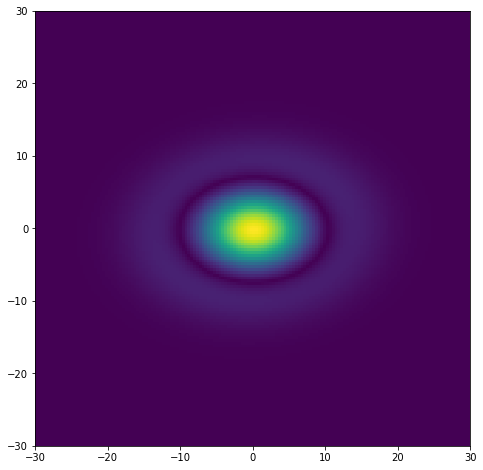

In [65]:
vis = np.flip(vis.T, axis = 0)
image_2dplot(np.abs(fft_now.real), lim = 30)

In [57]:
real_now, imag_now = 1, 1
sn = 10
num_mat = 10
real_noise, imag_noise = gauss_2d(real_now, imag_now, (((real_now**2 + imag_now**2)**0.5)/(sn * num_mat)**0.5))
print(real_noise, imag_noise)

0.9922528255309333 0.8379472044163534


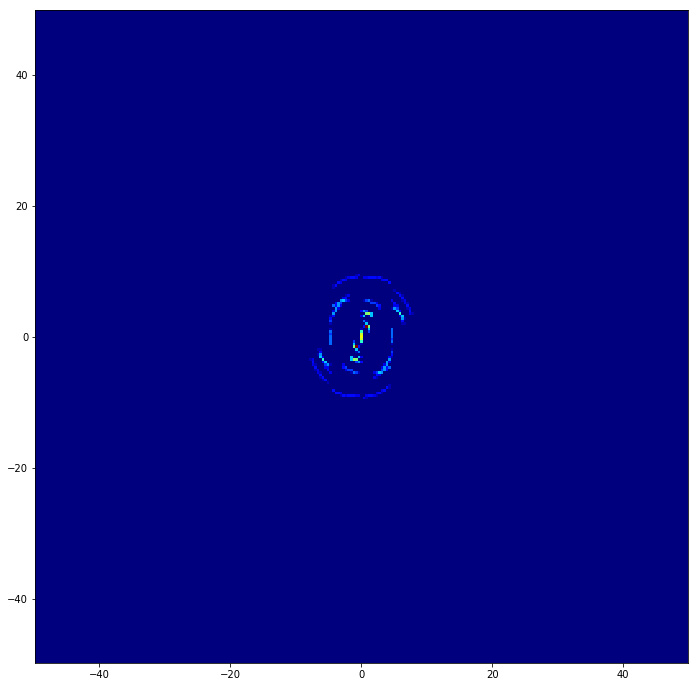

In [38]:




fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
plt.axes().set_aspect('equal')
num_mat= ax.hist2d(pos_arr[0],pos_arr[1], bins=[u_shift,v_shift], cmap=cm.jet)


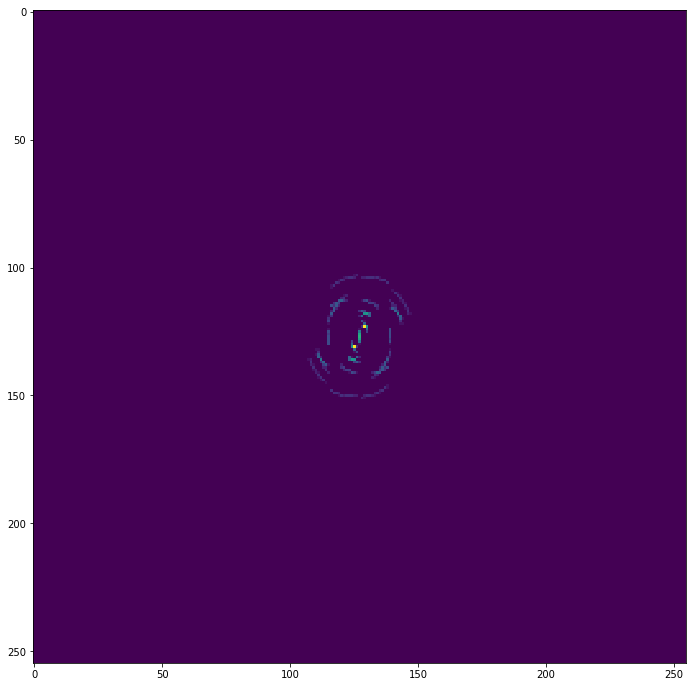

In [44]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(np.flip(num_mat[0].T, axis = 0))
plt.show()


In [ ]:
obs_ex.uv_vector(0, 0)
obs_ex.uv_vector(0, 0)